# Q-learning for Tic-Tac-Toe in Python

In [135]:
# installing dependencies
import math
import random
import matplotlib.pyplot as plt
import numpy as np

I chose to represent tic-tac-toe states using bitboards: binary numbers with each bit corresponding to a square on the board. A state can be represented using two binary numbers; one for naughts, and one for crosses. 

For example, the state:

o x o

_ x o

x _ _ 

Can be represented as naughts = 101001000 and crosses = 010010100. As a tuple of base-10 numbers, the state is (328, 148).

## Task 1: Listing all possible states

The first part of this task was figuring out how to check whether a state is valid. The first two conditions is easy: a bit can be occupied by at most one player, and the count of crosses and naughts on the board must be correct. The second condition, that the game must end after win, is a bit harder. I check this by checking the position against win masks to see if either player won, and then checking that the number of moves matches. 

Then all that remains is to check all possible numbers. I store the states in a dictionary by depth in order to make the next step easier. 

This is probably not the most efficient implementation, but it is pretty quick, simple and it works. 

In [136]:
"""This code creates a list all posittive valid states of tic-tac-toe as binary bitboard tuples."""

winning_positions = [0b000000111, # row 0
                  0b000111000, # row 1
                  0b111000000, # row 2
                  0b100100100, # column 0
                  0b010010010, # column 1
                  0b001001001, # column 2
                  0b100010001, # diagonal \
                  0b001010100 # diagonal /
]

def valid_state(naughts, crosses):
    """Checks whether the given tic-tac-toe bitboard represents a valid state of the game."""
    # Each square must be occupied by only one piece
    # So naughts AND crosses must return 0
    if naughts & crosses != 0:
        return 0
    # Number of crosses = number of naughts (or number of naughts + 1)
    # So if no_naughts > no_crosses or no_crosses > no_naughts + 1, invalid state
    n_o = naughts.bit_count()
    n_x = crosses.bit_count()
    if (n_o > n_x) or (n_x > n_o + 1):
        return 0
    # Determine whether there are any 'wins' (filled rows, columns, or diagonals) for naughts and for crosses
    x_wins = any((crosses & winning_pos) == winning_pos for winning_pos in winning_positions)
    o_wins = any((naughts & winning_pos) == winning_pos for winning_pos in winning_positions)
    # For a valid crosses win, number of crosses should = no. naughts + 1 
    if x_wins and n_x != n_o + 1:
        return 0
    # If naughts won, no. of naughts should = no. of crosses
    if o_wins and n_o != n_x:
        return 0
    # Remaining wins (and draws) must be valid
    if x_wins:
        return (1, n_o + n_x) # x won
    if o_wins:
        return (-1, n_o + n_x) # o won
    if n_o + n_x == 9:
        return (0, n_o + n_x) # draw
    # Cannot be a win so must be a valid game state. Return None to signify this as well as the depth of the game (no. of moves that have happened)
    return (None, n_o + n_x)

def return_states():
    """Returns all possible valid winning and gameplay states of tic-tac-toe."""
    possible_states = {} # dict mapping depth/no. of moves to list of states as tuples of binary numbers
    terminal_states = {} # dictionary mapping state to value (-1 for naughts wins, 1 for crosses wins, 0 for draw)
    # The greatest number that a naughts position can correspond to is 480 (111100000)
    # For a crosses position this is 496 (111110000)
    for naughts in range(0, 481):
        for crosses in range(0,497):
            result = valid_state(naughts, crosses)
            if result == 0:
                continue
            if result[0] == None:
                possible_states.setdefault(result[1], []).append((naughts, crosses))
            else:
                possible_states.setdefault(result[1], []).append((naughts, crosses))
                terminal_states[(naughts, crosses)] = result[0]
    return possible_states, terminal_states

possible_states, terminal_states = return_states()

# setting up counter variables
gameplay = 0
x_won = 0
o_won = 0
draw = 0

for statelist in possible_states.values():
    for state in statelist:
        if state not in terminal_states:
            gameplay += 1
        else:
            result = terminal_states[state]
            if result == 1:
                x_won += 1
            elif result == -1:
                o_won += 1
            else:
                draw += 1

print(f"There were {gameplay} valid non-winning states, and {x_won + o_won + draw} terminal states, making {gameplay + x_won + o_won + draw} total states.")
print(f"Of these, crosses won in {x_won}, naughts in {o_won}, and {draw} were a draw.")

There were 4520 valid non-winning states, and 958 terminal states, making 5478 total states.
Of these, crosses won in 626, naughts in 316, and 16 were a draw.


To check my answer, I add the states found to a txt file. First I implement a function to convert a bitboard to a string representation of a tic-tac-toe state, which I use frequently throughout the project.

In [137]:
"""This code implements a function that, given a list of all possible bitboard representations of a game of tic-tac-toe, converts it to a list of 
visual representations using x's and o's.

It writes the possible states generated into a txt file for review, along with a summary."""

def bitboard_to_visual(bitboard):
    """This function converts a bitboard representation of a tic-tac-toe board to a visual one (e.g. "oxo___ox_") and returns the result."""
    visual = list('_' for i in range(9)) # creating 'empty' list
    naughts, crosses = bitboard
    naughts, crosses = format(naughts, '09b'), format(crosses,'09b') # e.g. the binary number 0b011010000 becomes the string '011010000'
    for index, digit in enumerate(naughts):
        if digit == '1': # if naughts occupy this position
            visual[index] = 'o'
    for index, digit in enumerate(crosses):
        if digit == '1': # if crosses occupy this position
            visual[index] = 'x' 
    return ''.join(visual) # joining list to create a string and returning

with open("possible_states.txt", "w") as file:
    for statelist in possible_states.values(): # for list of states at a depth
        for state in statelist: # for state in this list
            file.write(f"{bitboard_to_visual(state)},\n") # append state to file
    # summary
    file.write(f"Crosses won {x_won} times\n")
    file.write(f"Naughts won {o_won} times\n")
    file.write(f"{draw} states were drawn\n")
    file.write(f"The remaining {gameplay} states were non-terminal, i.e. gameplay states\n")
    file.write(f"There were a total of {gameplay + x_won + o_won + draw} states")

## Task 2: Creating a 'perfect' q-table using dynamic programming

The next task is to use dynamic programming to fill up a q-table for an optimal opponent. A top-down approach is used, starting with the terminal states generated earlier, and moving down move by move from the eventual outcome. A dictionary is used to track the optimal outcome, allowing the optimal opponent assumption to be met. I initially used a list, but chose a dictionary in order to make the next task - playing the game - easier.

In [138]:
"""This code uses dynamic programming to create and fill a q-table with possible moves and Q-scores for each possible state of tic-tac-toe, and for an optimal 
opponent."""

# creating a dictionary of possible moves at each game state
# naughts OR crosses has 0 wherever there are two 0s in a position (free position) and 1 wherever a position is full
# 1 << i has the ith digit, starting at 0, being a 1 (since 1 is just 0b1, 1 << 3 for example is 0b1000) 
# so comparing these two results using the & operator (which gives 1 iff both values are 1) gives a number which has 1
# if the position is occupied and 0 if it is not; so we take those values of i for which the result is 0
moves_at_state = {}
for statelist in possible_states.values():
    for state in statelist:
        if state not in terminal_states: # nonterminal state
            naughts, crosses = state
            moves = [i for i in range(9) if not (naughts | crosses) & (1 << i)]
            moves_at_state[state] = moves

def create_q_table_optimal_opponent(): 
    # start with terminal states and their q-values
    q_table = {}
    for state, result in terminal_states.items():
        q_table[state] = {None: result}

    for depth in range(8, -1, -1): # initialise to states one move away from filling the board; increment down to 0 (starting state)
        for state in possible_states[depth]:
            if state not in terminal_states: # nonterminal state
                naughts, crosses = state
                available_moves = moves_at_state[state]

                moves_and_qs = {} # to keep track of the move which leads to the optimal outcome

                if depth % 2 == 0: # crosses' turn
                    for n in available_moves: # going through possible moves
                        next_state = (naughts, crosses | (1 << n)) # adding 2^n changes the nth position (starting from 0, going right to left) to a 1, if it is 0
                        q = min(q_table[next_state].values()) # opponent (naughts) will move optimally
                        moves_and_qs[n] = q  
                
                else: # naughts' turn
                    for n in available_moves:
                        next_state = (naughts | (1 << n), crosses)
                        q = max(q_table[next_state].values()) # opponent (crosses) will move optimally 
                        moves_and_qs[n] = q  
                
                q_table[(naughts, crosses)] = moves_and_qs # updating q-table
    
    return q_table

q_table_optimal_opponent = create_q_table_optimal_opponent()

The same is repeated but for a random opponent. The only difference is that the resultant q-value is the average of those of possible moves. 

In [139]:
"""This code uses dynamic programming to create and fill a q-table with possible moves and Q-scores for each possible state of tic-tac-toe, and for a random 
opponent."""

def create_q_table_random_opponent(): 
    q_table = {}
    for state, result in terminal_states.items():
        q_table[state] = {None: result}

    for depth in range(8, -1, -1): # initialise to states one move away from filling the board; increment down to 0 (starting state)
        for state in possible_states[depth]:
            if state not in terminal_states:
                naughts, crosses = state
                available_moves = moves_at_state[state]

                moves_and_qs = {} # to keep track of all possible moves and their results

                if depth % 2 == 0: # crosses' turn
                    for n in available_moves: # going through possible moves
                        next_state = (naughts, crosses | (1 << n)) # adding 2^n changes the nth position (starting from 0, going right to left) to a 1, if it is 0 
                        q = sum(q_table[next_state].values()) / len(q_table[next_state]) # this is q-value averaged over all the possible moves.
                        moves_and_qs[n] = q         
                
                else: # naughts' turn
                    for n in available_moves:
                        next_state = (naughts | (1 << n), crosses)
                        q = sum(q_table[next_state].values()) / len(q_table[next_state]) # this is q-value averaged over all the possible moves.
                        moves_and_qs[n] = q 
                    
                q_table[(naughts, crosses)] = moves_and_qs # updating q-table
    
    return q_table

q_table_random_opponent = create_q_table_random_opponent()

And again we create txt files to track our progress.

In [140]:
"""Given q-tables with bitboard representations of tic-tac-toe states, converts them to visual representations and writes them to a txt file, along with a summary."""

# counter variables
terminal = 0 
x_wins = 0
o_wins = 0
draws = 0
with open("q_table.txt", "w") as file:
    file.write("A move is represented by a number, which is the index (going from right to left, starting at 0) of the position to be occupied.\n")
    file.write("For example, Move: 0 indicates that the player occupied the bottom right square.\n")
    for state, move_q_dict in q_table_optimal_opponent.items():
        file.write(f"[{bitboard_to_visual(state)}] ")
        for move, q in move_q_dict.items():
            if move == None:
                file.write(f"Terminal q-value: {q};\n")
                terminal += 1
            else:
                file.write(f"Move: {move}, Q-value: {q}; ")
                if q == 1:
                    x_wins += 1
                if q == -1:
                    o_wins += 1
                if q == 0:
                    draws += 1
        file.write("\n")
    # summary
    file.write(f"{x_wins} moves led to crosses winning\n")
    file.write(f"{o_wins} moves led to naughts winning\n")
    file.write(f"{draws} moves led to a draw\n")
    file.write(f"{terminal} states were terminal.  {x_wins + o_wins + draws} state-move pairs were found\n")

# counter variables
terminal = 0 
x_wins = 0
o_wins = 0
draws = 0
with open("random_q_table.txt", "w") as file:
    file.write("A move is represented by a number, which is the index (going from right to left, starting at 0) of the position to be occupied.\n")
    file.write("For example, Move: 0 indicates that the player occupied the bottom right square.\n")
    for state, move_q_dict in q_table_random_opponent.items():
        file.write(f"[{bitboard_to_visual(state)}] ")
        for move, q in move_q_dict.items():
            if move == None:
                file.write(f"Terminal q-value: {q};")
                terminal += 1
            else:
                file.write(f"Move: {move}, Q-value: {q:.2f}; ")
                if q >= 0.5:
                    x_wins += 1
                elif q <= -0.5:
                    o_wins += 1
                else:
                    draws += 1
        file.write("\n")
    # summary
    file.write(f"{x_wins} moves were closer to crosses winning\n")
    file.write(f"{o_wins} moves were closer to naughts winning\n")
    file.write(f"{draws} moves were closer to a draw than to either side winning\n")
    file.write(f"{terminal} states were terminal. {x_wins + o_wins + draws} state-move pairs were found\n")

## Task 3: Simulating gameplay

This was a relatively short task, but a very important one for the implementation of q-learning. 

Starting with the outermost layer, we have a function which plays tic-tac-toe for a given number of games, using a given strategy for naughts and for crosses. It returns a list of games. Each game is itself a list, consisting of the tuples used to represent states, as well as an integer result. For the given number of games, we 'make moves' until a terminal state is achieved, and record the resulting states. 

But how do you 'make moves'? Well, we know the mechanism for that using bitwise operations; given a move, we can easily make it and return te. But we need to choose a move. 

To choose a move we implement our final function. If the player is random, a random move is chosen from the moves at that state. Otherwise, the move is chosen by maximising or minimising the q-value in the given q-table. 

Then, working back up, the game is played. 

In [141]:
"""Code to simulate tic-tac-toe gameplay. Each player can be either random, or given a q-table as input. The q-table may be either of those generated above,
or one generated by the q-learning below."""

def play_tic_tac_toe(games, x_strategy, o_strategy):
    """Function which plays the given number of games using the given strategy (random or optimal) for both agent and opponent."""
    gamecount = 0 # initialise game counter
    gamelist = [] # initialise game list which will contain a list of states and an integer result
    while gamecount < games:
        # initialise the game state
        gamestate = (0, 0)
        moves = []
        depth = 0
        while gamestate not in terminal_states: # continue playing until a terminal state is achieved
            if depth % 2 == 0: # crosses' turn
                gamestate = x_moves(gamestate, x_strategy)
            else:
                gamestate = o_moves(gamestate, o_strategy)
            moves.append(bitboard_to_visual(gamestate))
            depth += 1
        # record result of game
        moves.append(terminal_states[gamestate])
        gamelist.append(moves)
        # update game counter
        gamecount += 1

    # return list of states and result
    return gamelist

def x_moves(state, x_strategy):
    """Function which, given a state and a strategy for each"""
    naughts, crosses = state
    a = choose_action(state, x_strategy, 'x')
    new_state = (naughts, crosses | (1 << a))
    # return the new state s'
    return new_state

def o_moves(state, o_strategy):
    """Function which, given a state and a strategy for each"""
    naughts, crosses = state
    a = choose_action(state, o_strategy, 'o')
    new_state = (naughts | (1 << a), crosses)
    # return the new state s'
    return new_state

def choose_action(state, strategy, player):
    """"""
    # random strategy chooses with equal probabilities so Pr(a) = 1/N_a 
    if strategy == 'random':
        move = random.choice(moves_at_state[state])
    # otherwise, the input is a q-table. depending on the player the player will either maximise or minimise q-value
    elif player == 'x': # crosses' turn
        move = max(strategy[state], key=lambda x: strategy[state][x])
    else: # naughts' turn
        move = min(strategy[state], key=lambda x: strategy[state][x])
    return move


Now for some fun stuff: testing gameplay! Firstly we see how two random players fare; then how optimal crosses and random naughts fare; finally, random crosses and optimal naughts. (Skip over two optimal players because this always leads to a draw.)

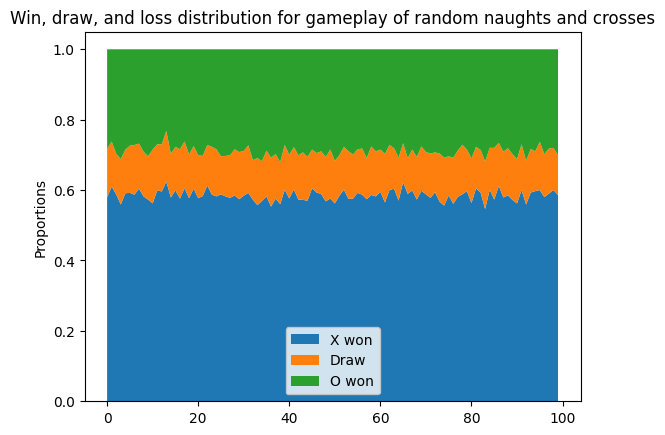

X won on average 58.43% of the time. O won on average 28.99% of the time. Draws occured on average 12.58% of the time.


In [142]:
"""This code plots the proportion of wins, losses and draws for x over a 100 iterations of 1000 games, for:
- random naughts and crosses"""

ws = []
ds = []
ls = []
for i in range(100):
    gamelist = play_tic_tac_toe(1000, 'random', 'random')
    x_wins = 0
    o_wins = 0
    draws = 0
    for game in gamelist:
        if game[-1] == 1:
            x_wins += 1
        elif game[-1] == -1:
            o_wins += 1
        else:
            draws += 1
    ws.append(x_wins/1000)
    ds.append(draws/1000)
    ls.append(o_wins/1000)
xs = np.arange(0, 100, 1)

plt.subplot()
plt.stackplot(xs, ws, ds, ls, labels=['X won', 'Draw', 'O won'])
plt.ylabel('Proportions')
plt.legend()
plt.title('Win, draw, and loss distribution for gameplay of random naughts and crosses')
plt.show()

print(f"X won on average {100 * sum(ws) / len(ws):.2f}% of the time. O won on average {100 * sum(ls) / len(ls):.2f}% of the time. Draws occured on average {100 * sum(ds) / len(ds):.2f}% of the time.")


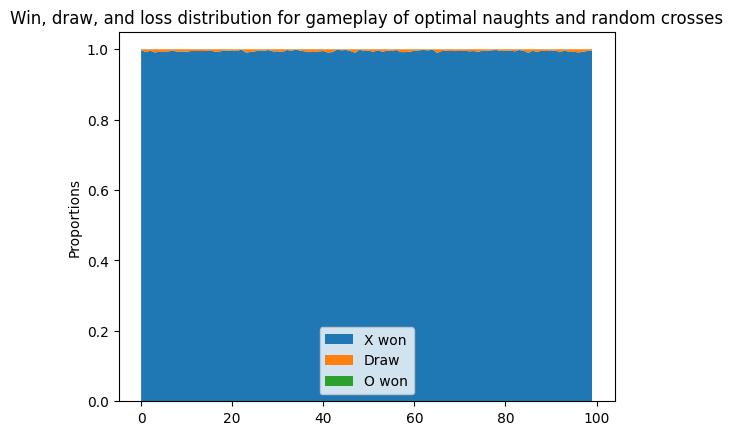

X won on average 99.49% of the time. O won on average 0.00% of the time. Draws occured on average 0.51% of the time.


In [143]:
"""This code plots the proportion of wins, losses and draws for x over a 100 iterations of 1000 games, for:
- random naughts, optimal crosses"""

ws = []
ds = []
ls = []
for i in range(100):
    gamelist = play_tic_tac_toe(1000, q_table_optimal_opponent, 'random')
    x_wins = 0
    o_wins = 0
    draws = 0
    for game in gamelist:
        if game[-1] == 1:
            x_wins += 1
        elif game[-1] == -1:
            o_wins += 1
        else:
            draws += 1
    ws.append(x_wins/1000)
    ds.append(draws/1000)
    ls.append(o_wins/1000)
xs = np.arange(0, 100, 1)

plt.subplot()
plt.stackplot(xs, ws, ds, ls, labels=['X won', 'Draw', 'O won'])
plt.ylabel('Proportions')
plt.legend()
plt.title('Win, draw, and loss distribution for gameplay of optimal naughts and random crosses')
plt.show()

print(f"X won on average {100 * sum(ws) / len(ws):.2f}% of the time. O won on average {100 * sum(ls) / len(ls):.2f}% of the time. Draws occured on average {100 * sum(ds) / len(ds):.2f}% of the time.")


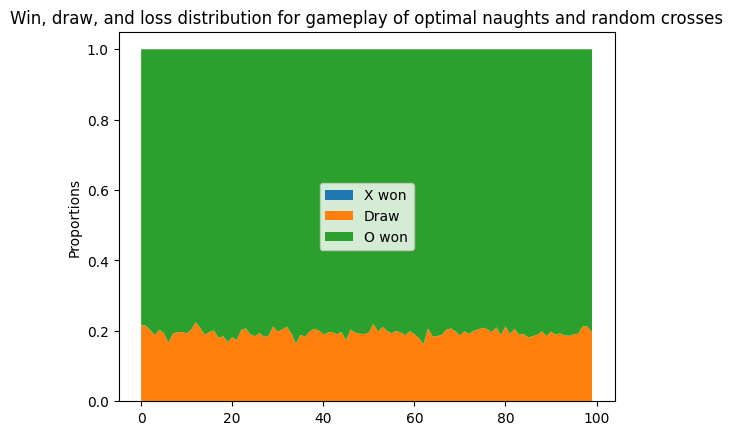

X won on average 0.00% of the time. O won on average 80.51% of the time. Draws occured on average 19.49% of the time.


In [144]:
"""This code plots the proportion of wins, losses and draws for x over a 100 iterations of 1000 games, for:
- random crosses, optimal naughts."""

ws = []
ds = []
ls = []
for i in range(100):
    gamelist = play_tic_tac_toe(1000, 'random', q_table_optimal_opponent)
    x_wins = 0
    o_wins = 0
    draws = 0
    for game in gamelist:
        if game[-1] == 1:
            x_wins += 1
        elif game[-1] == -1:
            o_wins += 1
        else:
            draws += 1
    ws.append(x_wins/1000)
    ds.append(draws/1000)
    ls.append(o_wins/1000)
xs = np.arange(0, 100, 1)

plt.subplot()
plt.stackplot(xs, ws, ds, ls, labels=['X won', 'Draw', 'O won'])
plt.ylabel('Proportions')
plt.legend()
plt.title('Win, draw, and loss distribution for gameplay of optimal naughts and random crosses')
plt.show()

print(f"X won on average {100 * sum(ws) / len(ws):.2f}% of the time. O won on average {100 * sum(ls) / len(ls):.2f}% of the time. Draws occured on average {100 * sum(ds) / len(ds):.2f}% of the time.")

## Task 4: Q-learning

Now the real gnarly stuff. This was by far the most difficult part of the project and had many conceptual trip-ups and little bugs.

The main framework of the code was the game-sim function from above. However, instead of simply recording states and the final outcome, I had to initialise a q-table with all the moves at each state, and then update it as the game was played, move by move. 

Optionally, the algorithm can be performed on an existing q-table, to 'improve' it.

In [145]:
"""This code generates a q-table using q-learning. Naughts and crosses can each be optimal, random or learning. Tau and alpha can be adjusted. Number of games played
can be adjusted. """

def q_learning(games, x_strategy, o_strategy, tau, alpha, q_table=None):
    """Function which plays the given number of games using the given strategy (random or optimal) for both agent and opponent."""
    # initialising resultant q-table
    # decided to use a dictionary mapping state to a dictionary
    # the 'inner' dictionary maps a move to an outcome
    if not q_table:
        q_table = {}
        for state, moves in moves_at_state.items():
            q_table[state] = {move: 0 for move in moves}

    gamecount = 0 # initialise game counter
    while gamecount < games:
        # initialise the game state
        gamestate = (0, 0)
        depth = 0
        while gamestate not in terminal_states: # continue playing until a terminal state is achieved
            if depth % 2 == 0: # crosses' turn
                # save previous gamestate (before crosses' move), s
                old = gamestate
                gamestate, move = q_learning_x_moves(q_table, gamestate, x_strategy, tau)
            else: # naughts' turn
                gamestate, move = q_learning_o_moves(q_table, gamestate, o_strategy, tau)
                if gamestate not in terminal_states: # if still not terminal after naughts' turn
                    optimal_future_value = max(q_table[gamestate].values())
                    q_table[old][move] += alpha * (optimal_future_value - q_table[old][move])
            depth += 1
        # update with terminal result
        q_table[old][move] += alpha * (terminal_states[gamestate] - q_table[old][move])
        # update game counter
        gamecount += 1
    # return list of states and result
    return q_table

def q_learning_x_moves(q_table, state, x_strategy, tau):
    """Function which, given a state and a strategy for crosses, makes a move and returns the resulting state"""
    naughts, crosses = state
    a = q_learning_choose_action(q_table, state, x_strategy, 'x', tau)
    new_state = (naughts, crosses | (1 << a))
    # return the new state s'
    return new_state, a

def q_learning_o_moves(q_table, state, o_strategy, tau):
    """Function which, given a state and a strategy for naughts, makes a move and returns the resulting state"""
    naughts, crosses = state
    a = q_learning_choose_action(q_table, state, o_strategy, 'o', tau)
    new_state = (naughts | (1 << a), crosses)
    # return the new state s'
    return new_state, a

def q_learning_choose_action(q_table, state, strategy, player, tau):
    """Function which, given a state, strategy, and player, picks a move for the player to make"""
    # random strategy chooses with equal probabilities so Pr(a) = 1/N_a 
    if strategy == 'random':
        move = random.choice(moves_at_state[state])
    elif strategy == 'learning':
        # Boltzmann function
        moves = moves_at_state[state]
        # first use vector operations to make a numpy array of q-values of all possible moves
        logits = np.array([q_table[state][a] for a in moves])
        # then normalise the q-values using Boltzmann to create the weights
        weights = np.exp(logits / tau) / np.exp(logits / tau).sum()
        # finally pick a move based on these weights
        move = int(np.random.choice(np.array(moves), p=weights))
    # otherwise, the input is a q-table. depending on the player the player will either maximise or minimise q-value
    elif player == 'x': # crosses' turn
        move = max(strategy[state], key=lambda x: strategy[state][x])
    else: # naughts' turn
        move = min(strategy[state], key=lambda x: strategy[state][x])
    return move

q_table = q_learning(1000, 'learning', 'random', 5, 0.1)


Now we export the q-table to a txt file, as before. 

In [146]:
"""Given a q-learned q-table with bitboard representations of tic-tac-toe states, converts them to visual representations and writes them to a txt file, 
along with a summary."""

# generating q-tables using the above function
q_table_vs_random = q_learning(1000, 'learning', 'random', 10, 0.5)
q_table_vs_optimal = q_learning(10000, 'learning', q_table_optimal_opponent, 10, 0.5)
q_table_both_learning = q_learning(1000, 'learning', 'learning', 10, 0.5)

with open("q_learning_table_vs_random.txt", "w") as file:
    file.write("A move is represented by a number, which is the index (going from right to left, starting at 0) of the position to be occupied.\n")
    file.write("For example, Move: 0 indicates that the player occupied the bottom right square.\n")
    for state, move_q_dict in q_table_vs_random.items():
        file.write(f"[{bitboard_to_visual(state)}] ")
        for move, q in move_q_dict.items():
            file.write(f"Move: {move}, q-value: {q}; ")
        file.write("\n")

with open("q_learning_table_vs_optimal.txt", "w") as file:
    file.write("A move is represented by a number, which is the index (going from right to left, starting at 0) of the position to be occupied.\n")
    file.write("For example, Move: 0 indicates that the player occupied the bottom right square.\n")
    for state, move_q_dict in q_table_vs_optimal.items():
        file.write(f"[{bitboard_to_visual(state)}] ")
        for move, q in move_q_dict.items():
            file.write(f"Move: {move}, q-value: {q}; ")
        file.write("\n")

with open("q_learning_table_both_learning.txt", "w") as file:
    file.write("A move is represented by a number, which is the index (going from right to left, starting at 0) of the position to be occupied.\n")
    file.write("For example, Move: 0 indicates that the player occupied the bottom right square.\n")
    for state, move_q_dict in q_table_both_learning.items():
        file.write(f"[{bitboard_to_visual(state)}] ")
        for move, q in move_q_dict.items():
            file.write(f"Move: {move}, q-value: {q}; ")
        file.write("\n")

## Task 5: Testing
Now we can run some tests. Firstly, the performance of different q-tables trained over time/over games played. 

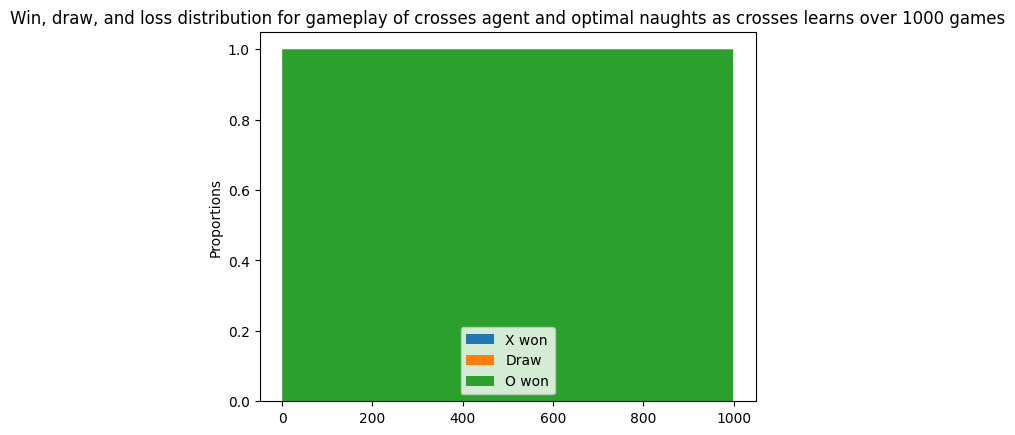

X won on average 0.00% of the time. O won on average 100.00% of the time. Draws occured on average 0.00% of the time.


In [147]:
"""This code plots the proportion of wins, losses and draws for x over 100 games after each of 1000 epsiodes of learning of one game each, for an agent training,
and playing, against an optimal player."""

ws = []
ds = []
ls = []
q_table = q_learning(1, 'learning', q_table_optimal_opponent, 5, 0.1)
for i in range(1000):
    q_table = q_learning(1, 'learning', q_table_optimal_opponent, 5, 0.1, q_table)
    gamelist = play_tic_tac_toe(100, q_table, q_table_optimal_opponent)
    x_wins = 0
    o_wins = 0
    draws = 0
    for game in gamelist:
        if game[-1] == 1:
            x_wins += 1
        elif game[-1] == -1:
            o_wins += 1
        else:
            draws += 1
    ws.append(x_wins/100)
    ds.append(draws/100)
    ls.append(o_wins/100)

xs = np.arange(0, 1000, 1)

plt.subplot()
plt.stackplot(xs, ws, ds, ls, labels=['X won', 'Draw', 'O won'])
plt.ylabel('Proportions')
plt.legend()
plt.title('Win, draw, and loss distribution for gameplay of crosses agent and optimal naughts as crosses learns over 1000 games')
plt.show()

print(f"X won on average {100 * sum(ws) / len(ws):.2f}% of the time. O won on average {100 * sum(ls) / len(ls):.2f}% of the time. Draws occured on average {100 * sum(ds) / len(ds):.2f}% of the time.")

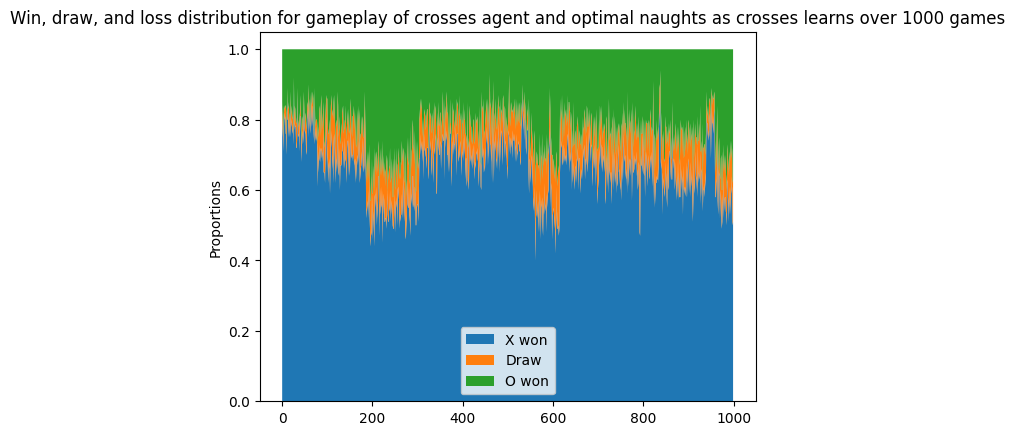

X won on average 66.50% of the time. O won on average 23.56% of the time. Draws occured on average 9.94% of the time.


In [148]:
"""This code plots the proportion of wins, losses and draws for x over 100 games after each of 1000 epsiodes of learning of one game each, for an agent training,
and playing, against a random player."""

ws = []
ds = []
ls = []
q_table = q_learning(1, 'learning', 'random', 5, 0.1)
for i in range(1000):
    q_table = q_learning(1, 'learning', 'random', 5, 0.1, q_table)
    gamelist = play_tic_tac_toe(100, q_table, 'random')
    x_wins = 0
    o_wins = 0
    draws = 0
    for game in gamelist:
        if game[-1] == 1:
            x_wins += 1
        elif game[-1] == -1:
            o_wins += 1
        else:
            draws += 1
    ws.append(x_wins/100)
    ds.append(draws/100)
    ls.append(o_wins/100)

xs = np.arange(0, 1000, 1)

plt.subplot()
plt.stackplot(xs, ws, ds, ls, labels=['X won', 'Draw', 'O won'])
plt.ylabel('Proportions')
plt.legend()
plt.title('Win, draw, and loss distribution for gameplay of crosses agent and optimal naughts as crosses learns over 1000 games')
plt.show()

print(f"X won on average {100 * sum(ws) / len(ws):.2f}% of the time. O won on average {100 * sum(ls) / len(ls):.2f}% of the time. Draws occured on average {100 * sum(ds) / len(ds):.2f}% of the time.")

We also test 